# CAM and Object Detection

CS 484 Final Project | by Kevin Guo (k56guo@uwaterloo.ca) and Ben Lin (b48lin@uwaterloo.ca)

## Abstract

The aim of this project is to obtain object detection for arbitrary images using Class Activation Mapping (CAM). For a general image and class, the goal is to locate areas of interest on the image that correlate with unique features of that class, if it exists in the image. We aim to apply this object detection method to different real world datasets and evaluate its performance.

We have used the approach described in _Learning Deep Features for Discriminative Localization_ by Zhou et al. In some classification networks, global average pooling computes the average of each channel of the last convolutional layer, then a weighted sum is applied to this vector to obtain a "score" for each class. Thus the score for class $c$ is equal to $\sum_k w^c_k F_k$, where $w^c_k$ is the weighting factor for class c applied to channel $k$ of the convolutional layer, and $F_k$ is the result of the global average pooling on channel $k$. Thus $w^c_k$ can be seen as a measure of importance of the feature $k$ for classifying class $c$. Since the convolutional layer is able to capture roughly where each feature is on the image, by multiplying each channel of the output by its weighting factor for a given class, and then summing them all together, we can produce a "heatmap" also called the Class Activation Mapping (CAM) which shows where the model predicts the class to be on the image.

In our project we use ResNet18, a popular image classification network, as our underlying model, and augment it for binary classification. To compute the CAM, we extract the output from the last convolutional layer, then multiply each channel of the output with its corresponding weighting factor (a learned parameter of the last fully connected layer). We have applied this approach to locate target classes of the ImageNet dataset in example pictures, and also to distinguish between emergency and non-emergency vehicles and find features that make the emergency vehicles identifiable.

## Team Members and Contributions

Kevin Guo: k56guo@uwaterloo.ca
- Implementing model training and testing pipelines
- Preparing the emergency vehicle dataset, and experimenting with label noise
- Fine-tuning classification models on the emergency vehicle dataset
- Writing the conclusion section and analysis throughout the notebook

Ben Lin: b48lin@uwaterloo.ca
- Implementing CAM heatmap generation for a trained model and target image
- Designing model architecture and training the models
- Fine-tuning classification models on the emergency vehicle dataset
- Writing the abstract section

## Code Libraries

These are the external libraries essential for our project:

- `torch` and `torchvision`: Standard libraries for ML and CV. We used the predefined ResNet18 model, as well as their pre-trained weights for the ImageNet dataset. We used the `transformations` submodule for data augmentation.
- `numpy`: Used for performing vectorized operations on arrays and tensors.
- `matplotlib`: Used `pyplot` submodule to display images.
- `tqdm`: Used to create quality-of-life progress bars during model training.
- `cv2` (installed as `opencv-python`): Used to load images, resize images, and apply colormaps.
- `sklearn` (installed as `scikit-learn`): We used the `model_selection.train_test_split` function to partition datasets in a random and stratified manner (i.e. ensures the partition maintains the proportional distribution of each class). We primarily use this function to split datasets into training and testing portions; we also use it to select a portion of the data to which we add label noise.

We also have our own library `model.py` in which we define our model architetures.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import cv2
from sklearn.model_selection import train_test_split

from mylibs.model import Resnet18, CNNClassifier

In [2]:
SEED = 1

# Use GPU if available, otherwise CPU. This significantly speeds up model training and evaluation.
device = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu')
print('Current Device:', device)

Current Device: cpu


## Generating CAMs

This is our implementation of CAMs.

In [3]:
# Generates the CAM heatmap and prediction for a given image, model, and target class.
#  img:           numpy array with shape (img_height, img_width, img_channels)
#  model:         model to use to generate prediction
#  target_class:  class for which to generate heatmap and prediction
#  transform:     transformations to be applied to img before passing to model
def cam(img, model, target_class=1, transform=None):
    model.eval()

    # Perform preprocessing image transformations
    sample_img = transforms.ToTensor()(img)
    if transform != None:
        sample_img = transform(sample_img)
    sample_img = sample_img.unsqueeze(0).to(device)
    model.to(device)
    feats = model.get_features(sample_img).data.cpu().numpy()
    
    # Get prediction probability for target class
    output = model(sample_img)
    logits = F.softmax(output, dim=1).squeeze()
    pred_logit = logits[target_class].item()

    # Build CAM
    _, nc, h, w = feats.shape
    r = feats.reshape((nc, h*w))

    params = list(model.parameters())
    weight = np.squeeze(params[-2].data.cpu().numpy())

    cam = weight[target_class] @ r
    cam = cam.reshape((h, w))
    cam = cam - np.min(cam)
    cam = cam / np.max(cam) if np.max(cam) > 0 else cam
    cam = np.uint8(255 * cam)
    cam = cv2.resize(cam, (img.shape[1], img.shape[0]))

    # Generate heatmap
    heatmap = cv2.cvtColor(cv2.applyColorMap(cam, cv2.COLORMAP_JET), cv2.COLOR_BGR2RGB)
    
    return heatmap, pred_logit

In [4]:
# Plots an image and its superimposed CAM side-by-side
def show_cam(img, heatmap, figsize=(6,4)):
    img = np.uint8(img)    
    img_heatmap = np.uint8(0.3 * heatmap + 0.5 * img)

    plt.figure(1, figsize=figsize)
    img_plot = plt.subplot(121)
    img_plot.axis('off')
    img_plot.imshow(img)
    cam_plot = plt.subplot(122)
    cam_plot.axis('off')
    cam_plot.imshow(img_heatmap)
    plt.show()

## Test 1: Pre-Trained ImageNet

Before using our CAM code on our own models, we first test it by generating some CAMs for the pretrained ResNet18 model on the ImageNet dataset.

In [5]:
model_default_imagenet = Resnet18(use_default_weights=True)

We will (arbitrarily) focus on the chainsaw class. This is class 491 out of the 1000 ImageNet classes. We will use some arbitrary images selected from the ImageNet validation dataset, as well as a tabby cat image from the Internet, for testing. This is to ensure that demonstration images are not in the training dataset of the model.

In [6]:
IMAGENET_CHAINSAW_CLASS = 491

chainsaws = [
    './examples/imagenet/chainsaw1.JPEG',
    './examples/imagenet/chainsaw2.JPEG'
]

not_chainsaws = [
    './examples/imagenet/cornet.JPEG',
    './examples/imagenet/golf.JPEG',
    './examples/tabby_cat.jpg'
]

In [7]:
# These are the transforms ImageNet uses when preprocessing input images.
IMAGENET_MEAN = [0.485, 0.456, 0.406]     
IMAGENET_STD = [0.229, 0.224, 0.225]
IMAGENET_TRANSFORMS = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((256,256)),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD)
])

Chainsaw Probability: 87.75302%


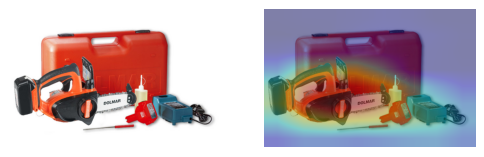

Chainsaw Probability: 89.55557%


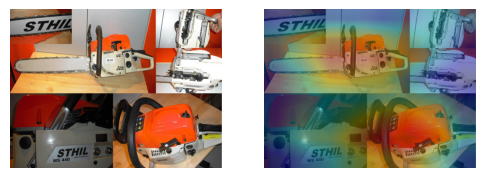

In [8]:
# Produce CAMs for chainsaw images
for im_path in chainsaws:
    im_raw = cv2.imread(im_path)
    im = cv2.cvtColor(im_raw, cv2.COLOR_BGR2RGB)
    heatmap, logit = cam(im, model_default_imagenet, 
                         IMAGENET_CHAINSAW_CLASS, 
                         IMAGENET_TRANSFORMS)
    print('Chainsaw Probability: {:.5f}%'.format(logit*100))
    show_cam(im, heatmap)

We see that the pre-trained ResNet18 model (unsurprisingly) correctly identifies that these images include chainsaws with high probability. The red regions of the CAM reveal what part of the images contributed the most to this classification: the red/black/silver body of the chainsaw is most relevant. In the second image, both chainsaws are relevant to the classification, so both chainsaws have been "identified" by the model.

Anthropomorphizing the model slightly, the red regions could be interpreted as the ones which the model thinks are most "chainsaw-like", and the blue regions could be interpreted as the ones which the model thinks are least "chainsaw-like".

Chainsaw Probability: 0.00040%


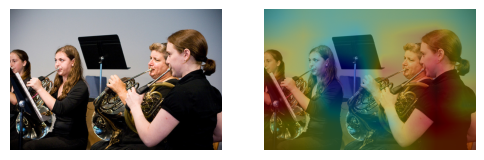

Chainsaw Probability: 0.00119%


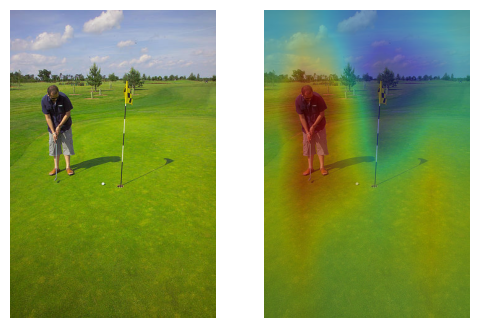

Chainsaw Probability: 0.00076%


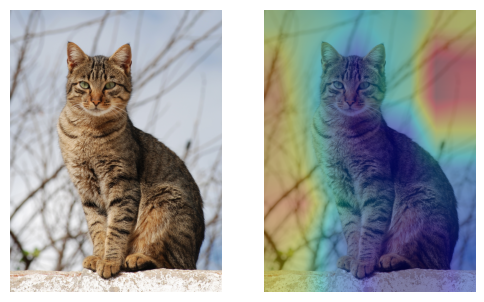

In [10]:
# Produce CAMs for non-chainsaw images
for im_path in not_chainsaws:
    im_raw = cv2.imread(im_path)
    im = cv2.cvtColor(im_raw, cv2.COLOR_BGR2RGB)
    heatmap, logit = cam(im, model_default_imagenet, 
                         IMAGENET_CHAINSAW_CLASS, 
                         IMAGENET_TRANSFORMS)
    print('Chainsaw Probability: {:.5f}%'.format(logit*100))
    show_cam(im, heatmap)

Again, the pre-trained model (unsurprisingly) correctly identifies that these images do not contain chainsaws. The blue regions of the CAMs can be interpreted as the regions that contributed the most to classification as a non-chainsaw.

We can also produce CAMs for any other class. Here are some CAMs for the tabby class:

Tabby Cat Probability: 0.00005%


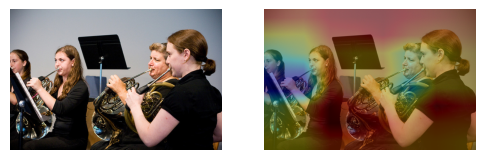

Tabby Cat Probability: 0.00008%


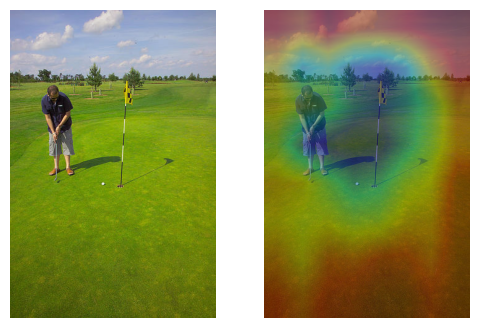

Tabby Cat Probability: 29.61389%


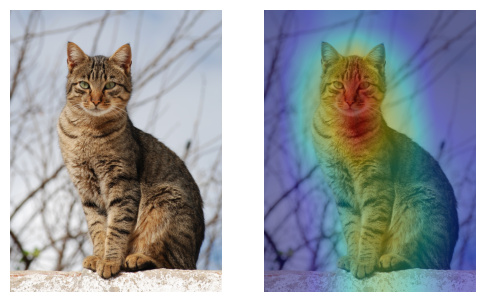

In [11]:
IMAGENET_TABBY_CLASS = 281

for im_path in not_chainsaws:
    im_raw = cv2.imread(im_path)
    im = cv2.cvtColor(im_raw, cv2.COLOR_BGR2RGB)
    heatmap, logit = cam(im, model_default_imagenet, 
                         IMAGENET_TABBY_CLASS, 
                         IMAGENET_TRANSFORMS)
    print('Tabby Cat Probability: {:.5f}%'.format(logit*100))
    show_cam(im, heatmap)

The model correctly classified the first two images as not-tabbies with high confidence, but the last image (the tabby) was classified with lower confidence than expected. We can investigate by peeking at the other logits of the model's classification:

In [12]:
tabby_path = not_chainsaws[-1]
im_raw = cv2.imread(tabby_path)
im = cv2.cvtColor(im_raw, cv2.COLOR_BGR2RGB)

sample_img = transforms.ToTensor()(im)
sample_img = IMAGENET_TRANSFORMS(sample_img)
sample_img = sample_img.unsqueeze(0).to(device)

output = model_default_imagenet(sample_img)
logits = F.softmax(output, dim=1).squeeze()
logits.shape

torch.Size([1000])

In [13]:
# For each ImageNet class i = 0, ..., 999, the model predicts that the image
#  belongs to class i with confidence logits[i].

# To interpret the top 5 most probable classifications, we need to convert these
#  class indices to the class names.

imagenet_class_to_idx = {}
with open('./datasets/imagenet_class_to_idx.txt') as dict_file:
    for ln in dict_file.readlines():
        tokens = ln.strip(' {').split(maxsplit=1)
        key = int(tokens[0][:-1])
        val = tokens[1].split(',')[0].strip('\' ,')
        imagenet_class_to_idx[key] = val

# First few ImageNet classes and their names:
print(list(imagenet_class_to_idx.items())[:10])

[(0, 'tench'), (1, 'goldfish'), (2, 'great white shark'), (3, 'tiger shark'), (4, 'hammerhead'), (5, 'electric ray'), (6, 'stingray'), (7, 'cock'), (8, 'hen'), (9, 'ostrich')]


In [14]:
print('Top 5 Model Predictions:')
sorted, indices = logits.sort(descending=True)
for i in range(5):
    c = indices[i].item()
    l = sorted[i].item()
    print('{:15} {:.2f}%'.format(imagenet_class_to_idx[c], l*100))

Top 5 Model Predictions:
Egyptian cat    38.62%
tabby           29.61%
tiger cat       26.37%
lynx            1.10%
plastic bag     0.89%


So we see that the model does correctly classify the image as a cat; the model is unsure about what type of cat is in the image.

To wrap up our first experiment, we can take a look at the CAM for the Egyptian cat class to speculate at why the model thinks this cat is an Egyptian cat:

Egyptian Cat Probability: 38.62092%


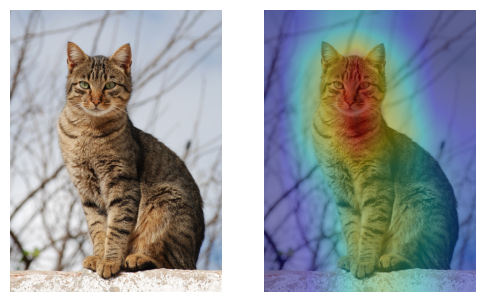

In [15]:
IMAGENET_EGYPTIAN_CAT_CLASS = 285

heatmap, logit = cam(im, model_default_imagenet, 
                    IMAGENET_EGYPTIAN_CAT_CLASS, 
                    IMAGENET_TRANSFORMS)
print('Egyptian Cat Probability: {:.5f}%'.format(logit*100))
show_cam(im, heatmap)

We see that the CAM looks very similar to the CAM for the Tabby class. The face of the cat is highlighted slightly redder in the Egyptian cat CAM, so perhaps the model is picking up on some facial features that are more similar to those of Egyptian cats in its training set.

Mild disclaimer: We don't know much about cat identification or cat features; we simply found this image by searching "tabby cat pictures" on Google Images.

## Test 2: Emergency Vehicles

For our next experiment, we train a classifier that identifies whether an emergency vehicle (i.e. police car, ambulance, or fire truck) is present in an image.

### Load Dataset

We use the following dataset from Kaggle uploaded by Abishek Singh: https://www.kaggle.com/datasets/abhisheksinghblr/emergency-vehicles-identification/data

The dataset consists of pictures which are labelled as either containing an emergency vehicle or not containing an emergency vehicle. The original dataset provides labels in a .csv file; we wrote a short Jupyter notebook to convert the data into a folder format compatible with `torchvision.datasets.ImageFolder`. The notebook can be found at `datasets/emergency_vehicles/label_data.ipynb`.

(224, 224, 3)


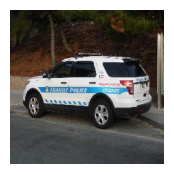

In [16]:
# Show an arbitrary image from the dataset
image = cv2.imread('./datasets/emergency_vehicles/labelled/emergency/1.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

print(image.shape)
plt.figure(1, figsize=(2,2))
plt.axis('off')
plt.imshow(image)
plt.show()

We perform data augmentation to increase the effectiveness of our model. Data augmentation produces new random images that are similar to the existing images in our dataset. Our training dataset is relatively small, so data augmentation led to a large improvement.

Our initial experimental model (without data augmentation) failed to effectively classify the emergency vehicles. In particular, it seemed to classify most red vehicle as emergency vehicles, and most other vehicles as non-emergency vehicles. By adding some random color jitter, we hope that the model learns other features of emergency vehicles and does not overfit to their color. The motivation behind the other transformations are similar: we do not want the model to overfit to a particular orientation, direction, or location of an emergency vehicle in the image. Thus, we use the following random transformations for data augmentation:

In [17]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomRotation(degrees=20),
    transforms.ColorJitter(brightness=0.3, hue=0.05, saturation=0.3),
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(size=224)
])

In [18]:
TRAIN_SIZE = 0.7

dataset = torchvision.datasets.ImageFolder('datasets/emergency_vehicles/labelled', transform)

# Use 70% of the data for training and 30% for validation
train_idx, val_idx = train_test_split(np.arange(len(dataset)),
                                           train_size=TRAIN_SIZE, 
                                           random_state=SEED, 
                                           stratify=dataset.targets)  # Maintain class balance when splitting
train_data = torch.utils.data.Subset(dataset, train_idx)
val_data = torch.utils.data.Subset(dataset, val_idx)

print('Dataset Size:', len(dataset))
print('Train Data Size:', len(train_data))
print('Validation Data Size:', len(val_data))

Dataset Size: 1646
Train Data Size: 1152
Validation Data Size: 494


Label: 0


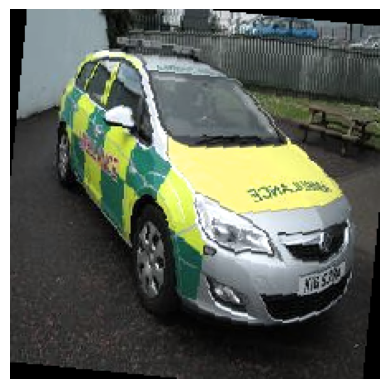

In [19]:
# A quick sanity check:
for img, label in dataset:
    print('Label: {}'.format(label)) # Emergency vehicles have label 0; non-emergency have label 1
    plt.axis('off')
    plt.imshow(img.permute(1,2,0))
    plt.show()
    break

# Repeatedly running this cell should produce a slightly different image each time
# (this is due to the randomized transformations used in data augmentation)

In [20]:
# Create dataloaders
BATCH_SIZE = 50

train_loader = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=False)

In [21]:
# Note that emergency vehicles have label 0, and non-emergency vehicles have label 1
n_data = len(dataset)
n_notemergency = sum(label for label in dataset.targets)
n_emergency = n_data - n_notemergency
print('Emergency Vehicle Images:', n_emergency)
print('Not Emergency Vehicle Images:', n_notemergency)

Emergency Vehicle Images: 681
Not Emergency Vehicle Images: 965


### Train Model

Since there are an unequal amount of emergency vehicle images and non-emergency-vehicle images in the dataset, we must modify the loss function to use appropriate weights. Misclassification of emergency vehicles (the less common class) need to be penalized proportionally heavier than misclassification of non-emergency vehicles (the more common class).

In [22]:
class_weights = torch.tensor([n_data/n_emergency, n_data/n_notemergency])

model = CNNClassifier(num_classes=2)
lr = 0.008
criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [23]:
def train(model, data_loader, criterion, optimizer):
    model.train()
    model.to(device)

    running_loss = 0.
    running_steps = 0
    n_correct = 0
    n_total = 0

    with tqdm(data_loader, desc ="   train") as train_tqdm:
        for inputs, targets in train_tqdm:
            inputs, targets = inputs.to(device), targets.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            running_steps += 1

            _, pred = torch.max(outputs, 1)
            n_correct += (pred==targets).sum().item()
            n_total += len(targets)

            average_train_loss = running_loss / running_steps
            accuracy = n_correct / n_total * 100.

            train_tqdm.set_postfix(loss=average_train_loss, accuracy=accuracy)

    return average_train_loss, accuracy

In [24]:
@torch.no_grad()
def test(model, data_loader, criterion, optimizer):
    model.eval()
    model.to(device)

    running_loss = 0.
    running_steps = 0
    n_correct = 0
    n_total = 0

    with tqdm(data_loader, desc ="   test") as test_tqdm:
        for inputs, targets in test_tqdm:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)

            loss = criterion(outputs, targets)
            running_loss += loss.item()
            running_steps += 1

            _, pred = torch.max(outputs, 1)
            n_correct += (pred==targets).sum().item()
            n_total += len(targets)
    
        average_test_loss = running_loss / running_steps
        accuracy = n_correct / n_total * 100.

        test_tqdm.set_postfix(loss=average_test_loss, accuracy=accuracy)

    return average_test_loss, accuracy

In [ ]:
TRAIN = False

# Skip this cell for faster execution when not actually training the model.
if TRAIN:
    for i in range(100):
        train_avg_loss, train_accuracy = train(model, train_loader, criterion, optimizer)
        if (i+1)%10 == 0:
            val_avg_loss, val_accuracy = test(model, val_loader, criterion, optimizer)
            print('Epoch: {:3d}, Train Average Loss: {:.2f}, Train Accuracy: {:.1f}%, ' +
                  'Validation Average Loss: {:.2f}, Validation Accuracy: {:.1f}%'\
                .format(i+1, train_avg_loss, train_accuracy, val_avg_loss, val_accuracy))

   test: 100%|██████████| 10/10 [00:05<00:00,  1.92it/s]


Epoch:  10, Train Average Loss: 0.80, Train Accuracy: 55.8%, Validation Average Loss: 0.72, Validation Accuracy: 47.8%


   test: 100%|██████████| 10/10 [00:04<00:00,  2.02it/s]


Epoch:  20, Train Average Loss: 0.69, Train Accuracy: 58.0%, Validation Average Loss: 0.68, Validation Accuracy: 58.7%


   test: 100%|██████████| 10/10 [00:05<00:00,  1.91it/s]


Epoch:  30, Train Average Loss: 0.66, Train Accuracy: 58.6%, Validation Average Loss: 0.72, Validation Accuracy: 54.7%


   test: 100%|██████████| 10/10 [00:05<00:00,  1.88it/s]


Epoch:  40, Train Average Loss: 0.53, Train Accuracy: 74.8%, Validation Average Loss: 0.60, Validation Accuracy: 66.6%


   test: 100%|██████████| 10/10 [00:05<00:00,  1.84it/s]


Epoch:  50, Train Average Loss: 0.38, Train Accuracy: 82.6%, Validation Average Loss: 0.93, Validation Accuracy: 65.0%


   test: 100%|██████████| 10/10 [00:05<00:00,  1.81it/s]


Epoch:  60, Train Average Loss: 0.34, Train Accuracy: 85.2%, Validation Average Loss: 0.81, Validation Accuracy: 68.8%


   test: 100%|██████████| 10/10 [00:04<00:00,  2.05it/s]


Epoch:  70, Train Average Loss: 0.38, Train Accuracy: 82.8%, Validation Average Loss: 0.67, Validation Accuracy: 65.0%


   test: 100%|██████████| 10/10 [00:04<00:00,  2.02it/s]


Epoch:  80, Train Average Loss: 0.29, Train Accuracy: 88.4%, Validation Average Loss: 0.99, Validation Accuracy: 61.9%


   test: 100%|██████████| 10/10 [00:04<00:00,  2.06it/s]


Epoch:  90, Train Average Loss: 0.23, Train Accuracy: 90.4%, Validation Average Loss: 0.35, Validation Accuracy: 84.4%


   test: 100%|██████████| 10/10 [00:04<00:00,  2.04it/s]

Epoch: 100, Train Average Loss: 0.29, Train Accuracy: 89.0%, Validation Average Loss: 0.38, Validation Accuracy: 84.4%


In [ ]:
val_avg_loss, val_accuracy = test(model, val_loader, criterion, optimizer)
print('Validation Average Loss: {:.2f}, Validation Accuracy: {:.1f}%'\
             .format(val_avg_loss, val_accuracy))

   test: 100%|██████████| 10/10 [00:05<00:00,  1.81it/s]

Validation Average Loss: 0.40, Validation Accuracy: 83.4%


### Test the model!

We now generate some CAMs for some test images.

In [25]:
model_emergency_vehicles = CNNClassifier(num_classes=2)
model_emergency_vehicles.load_state_dict(torch.load('./models/emergency_vehicles.pth', map_location=device))
print('Model loaded successfully.')

Model loaded successfully.


In [26]:
vehicle_paths = [
    './examples/emergency_vehicles/8.jpg',
    './examples/emergency_vehicles/13.jpg',
    './examples/emergency_vehicles/18.jpg',
    './examples/emergency_vehicles/2312.jpg',
    './examples/emergency_vehicles/2317.jpg',
    './examples/emergency_vehicles/2318.jpg',
    './examples/emergency_vehicles/2349.jpg'
]

Emergency Vehicle Probability: 99.99981%


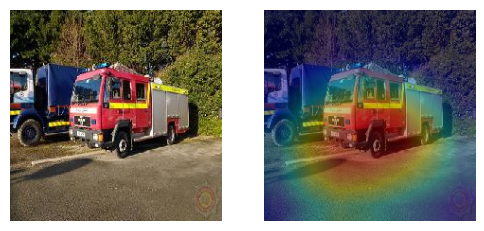

Emergency Vehicle Probability: 99.99995%


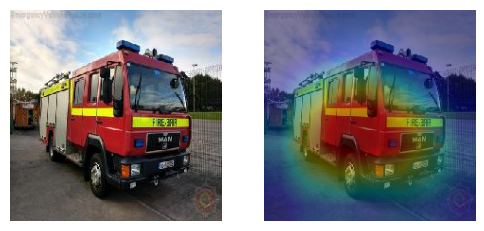

Emergency Vehicle Probability: 100.00000%


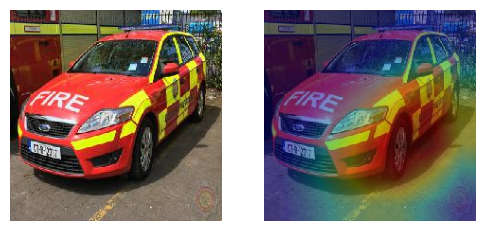

Emergency Vehicle Probability: 10.75368%


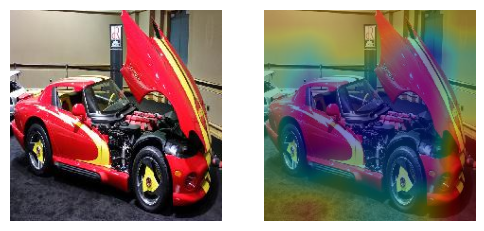

Emergency Vehicle Probability: 7.17148%


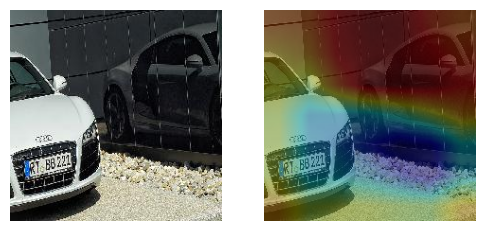

Emergency Vehicle Probability: 7.17302%


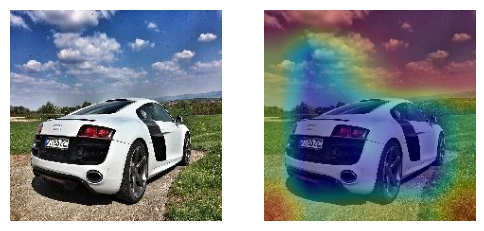

Emergency Vehicle Probability: 4.66707%


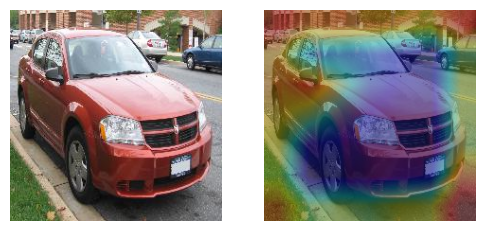

In [27]:
for im_path in vehicle_paths:
    im_raw = cv2.imread(im_path)
    im = cv2.cvtColor(im_raw, cv2.COLOR_BGR2RGB)
    heatmap, logit = cam(im, model_emergency_vehicles, target_class=0)
    print('Emergency Vehicle Probability: {:.5f}%'.format(logit*100))
    show_cam(im, heatmap)

We see that the model performs well! All images with emergency vehicles are classified with high probability, and all images with normal vehicles also correctly display low probability.

For the CAMs with emergency vehicles in them, we see that the front panels of the emergency vehicles are highlighted in red. Similarly, the fronts of the non-emergency vehicles are highlighted in blue. The CAMs reveal that the model has identified that some features in the fronts of vehicles are predictive of whether a vehicle is an emergency vehicle.

Additionally, we see that the model is not identifying features of emergency vehicles in the windshield and windows of vehicles, as well as roads, sidewalks, trees, skies, or other background elements. These regions are all blue in the emergency vehicle CAMs. This is as expected; most vehicles have similar-looking windshields and windows, and any image of a vehicle, emergency or not, can have similar backgrounds. The unique features of emergency vehicles are not located in these regions.

## Test 3: Emergency Vehicles with Label Noise

In this section, we try flip the labels of some percentage of the training dataset, then we retrain the model on that corrupted dataset. We trained two separate models; one where we flipped labels of 5% of the data, and one where we flipped labels of 10% of the data.

Note that we only corrupt the training dataset; we do not add noise to the validation dataset. The validation dataset is always our ground truth.

For brevity, we will only show the training code for the 10% noise trial. The training code for the 5% experiment is identical apart from the `CORRUPT_SIZE` parameter below.

In [28]:
CORRUPT_SIZE = 0.1

# Use train_test_split to randomly sample indices to be corrupted
# The 'stratify' parameter ensures a proportional amount of each class is chosen
corrupt_idx, no_corrupt_idx = train_test_split(train_idx,
                                  train_size=CORRUPT_SIZE,
                                  random_state=SEED,
                                  stratify=np.array(dataset.targets)[train_idx])

print('Total Training Datapoints:', len(train_idx))
print('Corrupt Datapoints:', len(corrupt_idx))
print('Non-corrupt Datapoints:', len(no_corrupt_idx))

Total Training Datapoints: 1152
Corrupt Datapoints: 115
Non-corrupt Datapoints: 1037


In [29]:
dataset_noisy = torchvision.datasets.ImageFolder('datasets/emergency_vehicles/labelled', transform)

# Convert 1-labels to 0-labels and vice-versa
for idx in corrupt_idx:
    dataset_noisy.targets[idx] = 1-dataset_noisy.targets[idx]

train_data_noisy = torch.utils.data.Subset(dataset_noisy, train_idx)

In [30]:
# Create dataloaders
BATCH_SIZE = 50

train_loader_noisy = torch.utils.data.DataLoader(train_data_noisy, batch_size=BATCH_SIZE, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=False)

### Train Model

In [31]:
# Note that emergency vehicles have label 0, and non-emergency vehicles have label 1
n_data = len(dataset)
n_notemergency = sum(label for label in dataset.targets)
n_emergency = n_data - n_notemergency
print('Emergency Vehicle Images:', n_emergency)
print('Not Emergency Vehicle Images:', n_notemergency)

Emergency Vehicle Images: 681
Not Emergency Vehicle Images: 965


In [32]:
# Use class weights to combat imbalanced dataset classes; same as in Test 2
class_weights = torch.tensor([n_data/n_emergency, n_data/n_notemergency])

model_noisy = CNNClassifier(num_classes=2)
lr = 0.008
criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))
optimizer = torch.optim.Adam(model_noisy.parameters(), lr=lr)

In [ ]:
TRAIN = False

# Skip this cell for faster execution when not actually training the model.
if TRAIN:
    for i in range(100):
        train_avg_loss, train_accuracy = train(model_noisy, train_loader, criterion, optimizer)
        if (i+1)%10 == 0:
            val_avg_loss, val_accuracy = test(model_noisy, val_loader, criterion, optimizer)
            print('Epoch: {:3d}, Train Average Loss: {:.2f}, Train Accuracy: {:.1f}%, ' +
                  'Validation Average Loss: {:.2f}, Validation Accuracy: {:.1f}%'\
                .format(i+1, train_avg_loss, train_accuracy, val_avg_loss, val_accuracy))

   test: 100%|██████████| 10/10 [00:06<00:00,  1.67it/s]


Epoch:  10, Train Average Loss: 0.88, Train Accuracy: 58.8%, Validation Average Loss: 0.99, Validation Accuracy: 54.5%


   test: 100%|██████████| 10/10 [00:06<00:00,  1.58it/s]


Epoch:  20, Train Average Loss: 0.61, Train Accuracy: 70.5%, Validation Average Loss: 1.96, Validation Accuracy: 54.7%


   test: 100%|██████████| 10/10 [00:06<00:00,  1.56it/s]


Epoch:  30, Train Average Loss: 0.44, Train Accuracy: 80.5%, Validation Average Loss: 0.67, Validation Accuracy: 75.1%


   test: 100%|██████████| 10/10 [00:06<00:00,  1.59it/s]


Epoch:  40, Train Average Loss: 0.32, Train Accuracy: 85.6%, Validation Average Loss: 0.39, Validation Accuracy: 83.6%


   test: 100%|██████████| 10/10 [00:06<00:00,  1.59it/s]


Epoch:  50, Train Average Loss: 0.54, Train Accuracy: 76.8%, Validation Average Loss: 0.46, Validation Accuracy: 78.5%


   test: 100%|██████████| 10/10 [00:06<00:00,  1.58it/s]


Epoch:  60, Train Average Loss: 0.36, Train Accuracy: 86.9%, Validation Average Loss: 0.56, Validation Accuracy: 74.5%


   test: 100%|██████████| 10/10 [00:06<00:00,  1.60it/s]


Epoch:  70, Train Average Loss: 0.28, Train Accuracy: 89.2%, Validation Average Loss: 0.37, Validation Accuracy: 83.4%


   test: 100%|██████████| 10/10 [00:05<00:00,  1.71it/s]


Epoch:  80, Train Average Loss: 0.32, Train Accuracy: 87.7%, Validation Average Loss: 0.59, Validation Accuracy: 72.9%


   test: 100%|██████████| 10/10 [00:05<00:00,  1.70it/s]


Epoch:  90, Train Average Loss: 0.42, Train Accuracy: 89.2%, Validation Average Loss: 0.41, Validation Accuracy: 83.4%


   test: 100%|██████████| 10/10 [00:06<00:00,  1.58it/s]

Epoch: 100, Train Average Loss: 0.30, Train Accuracy: 89.2%, Validation Average Loss: 0.43, Validation Accuracy: 80.6%


In [ ]:
val_avg_loss, val_accuracy = test(model_noisy, val_loader, criterion, optimizer)
print('Validation Average Loss: {:.2f}, Validation Accuracy: {:.1f}%'\
             .format(val_avg_loss, val_accuracy))

   test: 100%|██████████| 10/10 [00:06<00:00,  1.56it/s]

Validation Average Loss: 0.42, Validation Accuracy: 81.2%


### Test the model! (5% label noise)

We first test the model where 5% of the training dataset is corrupted.

In [33]:
model_vehicles_noisy_5 = CNNClassifier(num_classes=2)
model_vehicles_noisy_5.load_state_dict(torch.load('./models/emergency_vehicles_noisy-5percent.pth', map_location=device))
print('Model loaded successfully.')

Model loaded successfully.


Emergency Vehicle Probability: 99.93698%


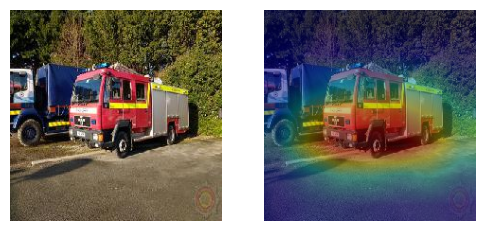

Emergency Vehicle Probability: 99.77521%


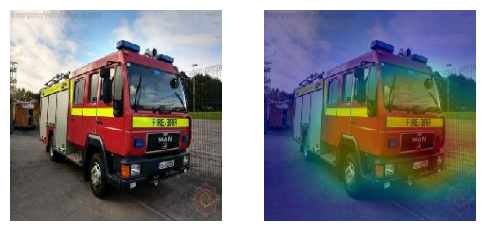

Emergency Vehicle Probability: 99.76319%


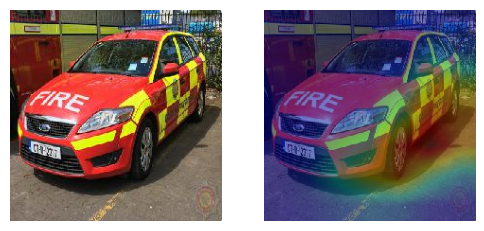

Emergency Vehicle Probability: 8.23828%


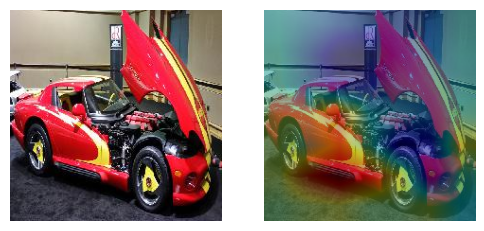

Emergency Vehicle Probability: 1.17438%


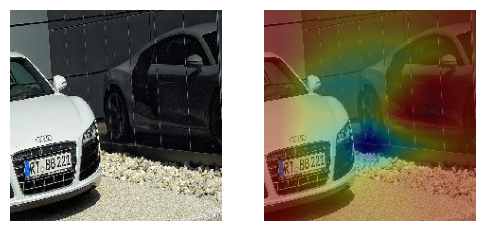

Emergency Vehicle Probability: 6.35349%


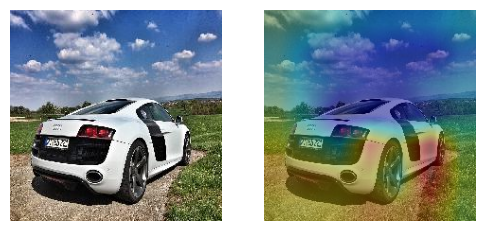

Emergency Vehicle Probability: 29.49698%


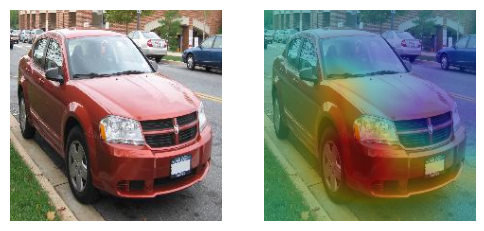

In [34]:
for im_path in vehicle_paths:
    im_raw = cv2.imread(im_path)
    im = cv2.cvtColor(im_raw, cv2.COLOR_BGR2RGB)
    heatmap, logit = cam(im, model_vehicles_noisy_5, target_class=0)
    print('Emergency Vehicle Probability: {:.5f}%'.format(logit*100))
    show_cam(im, heatmap)

The results are fairly similar to the results in our initial experiment with no label noise! Again the CAM seems to pick up on the front panels of the vehicles, and correctly ignores the background, as well as ignoring the windshield and windows.

In the last image, the model is no longer as confident that the image does not contain an emergency vehicle. We see that the front panel of this red car is highlighted in red in the CAM.

Side note: We found it funny that in the 3rd image, the hood of the vehicle was completely blue in the CAM. A human would easily identify this vehicle as an emergency vehicle due to the word "FIRE" on the hood -- but ML models don't think like humans! (and this model can't read)

### Test the model! (10% label noise)

We now test the model where 10% of the training dataset is corrupted.

In [35]:
model_vehicles_noisy_10 = CNNClassifier(num_classes=2)
model_vehicles_noisy_10.load_state_dict(torch.load('./models/emergency_vehicles_noisy-10percent.pth', map_location=device))
print('Model loaded successfully.')

Model loaded successfully.


Emergency Vehicle Probability: 99.22290%


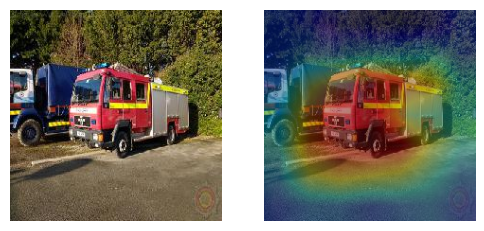

Emergency Vehicle Probability: 99.93243%


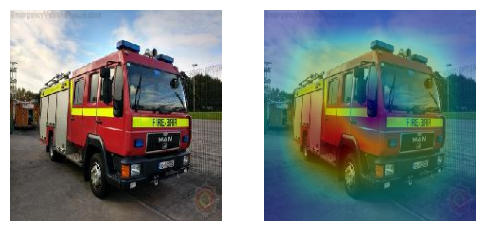

Emergency Vehicle Probability: 99.99579%


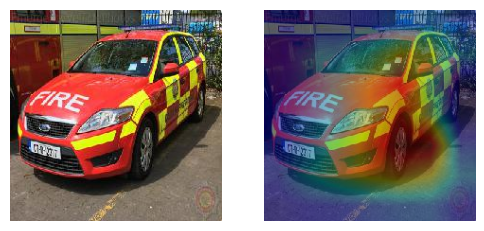

Emergency Vehicle Probability: 54.92673%


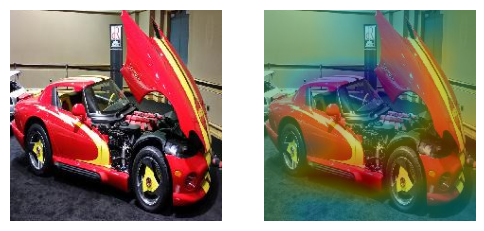

Emergency Vehicle Probability: 8.15908%


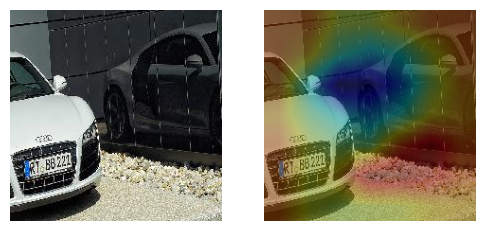

Emergency Vehicle Probability: 4.71215%


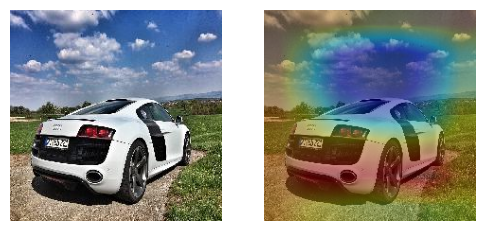

Emergency Vehicle Probability: 16.10502%


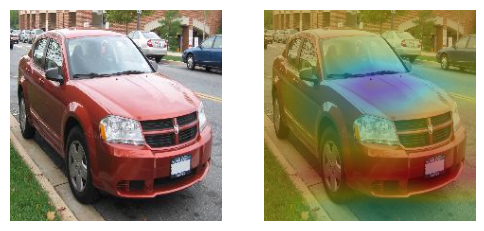

In [36]:
for im_path in vehicle_paths:
    im_raw = cv2.imread(im_path)
    im = cv2.cvtColor(im_raw, cv2.COLOR_BGR2RGB)
    heatmap, logit = cam(im, model_vehicles_noisy_10, target_class=0)
    print('Emergency Vehicle Probability: {:.5f}%'.format(logit*100))
    show_cam(im, heatmap)

We again see similar results as before, but the classification confidence is even lower. One misclassification is made in the 4th image. 

## Next Steps

Here are some further areas for investigation that we considered:

- Semantic Segmentation from CAMs: For a well-trained model, the CAM should correlate to the unique features of the target class. If the unique features are located on the target object, then the CAM can indicate where in the image the object is located. One possible approach is performing thresholding on the heatmap (declare a pixel as belonging to the target class iff the CAM heatmap value exceeds a threshold); another approach is building a bounding box off of the peak points in the CAM.
- Grad-CAM, Guided Grad-CAM, and Ablation-CAM: We learned about these extensions to CAMs as part of our initial research. Our implementation of CAM works only for CNNs with exactly one fully-connected (FC) layer after the convolutional layers; Grad-CAM extends the CAM approach to CNNs with multiple such FC layers. Guided Grad-CAM and Ablation-CAM seek to remedy some additional problems introduced by Grad-CAMs. It would be instructive to contrast the performance of CAM, Grad-CAM, Guided Grad-CAM, and Ablation-CAM.

## Conclusion

Our model effectively classifies whether an emergency vehicle is present or not, as can be seen in the test images above. When there is no label noise, all classifications were correct and confident. When 5% label noise was introduced, classifications were still correct, but confidence were lower. When 10% label noise was introduced, confidence was lower still and some misclassifications were made, but the model was still fairly accurate.

To regularize the model and combat label noise, we implemented data augmentation (random color jitter, rotations, flipping, and cropping). This helped prevent overfitting to our relatively small dataset, and this helped our model learn true features of the emergency vehicles. In particular, this stopped our model from making predictions that focus too much on the color of the vehicle and classifying all red vehicles as emergency vehicles.

CAMs provided us insight into why the model makes its predictions. We saw that our model identified features of emergency vehicles in the front panels. We also saw that the model does not place high importance in the windshields and windows of vehicles, nor in the backgrounds of the images. These CAMs reveal that the model is likely doing what we want: the model is likely picking up on unique features of emergency vehicles, and not making decisions based on portions of the vehicles common to all vehicles, nor making decisions based on the backgrounds of images.

CAMs allow us to take a peek under the hood of a CNN. The ability to explain what an ML model is doing allows for more effective, more robust, and safer development -- the developer can determine if the model is making predictions using undesired portions of the image, and tweak the model as necessary. Ultimately, CAMs are useful tool for investigating what is going on inside the black box of a CNN.